# Homework 3

DUE Nov 15th at 11:59 PM

In [4]:
import pandas as pd
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import itertools

## Problem 1

In this problem, you will implement a simple feed-forward neural network using PyTorch, a straight-forward and simple-to-pickup framework for quickly prototyping deep learning model. 

PyTorch provides 2 powerful things. First, a nice data structure called Tensor (basically a matrix, similar to Numpy ndarray). Tensor is optimized for matrix calculation and can be loaded to a GPU. Tensor is also implemented so that it's easy to calculate and pass back chains of gradients, which is extremely useful for backpropagation on neural network. Second, a nice inner mechanism called Autograd that nicely maps variables involved a chain of calculations and efficiently calculates their gradients via the chain rule when needed. Read more here: https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95  

You will define a neural network class in PyTorch and use the network to learn a classification task on the famous KDD CUP 99 dataset. You can refer to Problem 2 to see how a network class can be defined, how to use a PyTorch's DataLoader, and how a training loop may looks like.

There are many greate tutorial on PyTorch out there. For example, this video on Youtube explains how to build a simple network in PyTorch quite clearly: https://www.youtube.com/watch?v=oPhxf2fXHkQ

### Part a
Firstly, load and inspect the "**KDD CUP 99**" dataset.

In [3]:
from sklearn.datasets import fetch_kddcup99
from sklearn.preprocessing import OrdinalEncoder
X, y = fetch_kddcup99(return_X_y=True, percent10=True)

In [4]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0,b'tcp',b'http',b'SF',181,5450,0,0,0,0,...,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,0,b'tcp',b'http',b'SF',239,486,0,0,0,0,...,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,0,b'tcp',b'http',b'SF',235,1337,0,0,0,0,...,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0,b'tcp',b'http',b'SF',219,1337,0,0,0,0,...,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0,b'tcp',b'http',b'SF',217,2032,0,0,0,0,...,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,b'tcp',b'http',b'SF',310,1881,0,0,0,0,...,86,255,1.0,0.0,0.01,0.05,0.0,0.01,0.0,0.0
494017,0,b'tcp',b'http',b'SF',282,2286,0,0,0,0,...,6,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0
494018,0,b'tcp',b'http',b'SF',203,1200,0,0,0,0,...,16,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0
494019,0,b'tcp',b'http',b'SF',291,1200,0,0,0,0,...,26,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0


In [5]:
# convert the X dataset to a dataframe and factorize the columns
X_pd = pd.DataFrame(X)
X_pd['class'] = y
X_pd.iloc[:,1] = pd.factorize(X_pd.iloc[:,1])[0]
X_pd.iloc[:,2] = pd.factorize(X_pd.iloc[:,2])[0]
X_pd.iloc[:,3] = pd.factorize(X_pd.iloc[:,3])[0]
X_pd.loc[:,'class'] = pd.factorize(X_pd.loc[:,'class'])[0]

# separate y as its own variable
use_y = np.array(X_pd.loc[:,'class'])

# drop the class variable from the dataset
X_pd = X_pd.drop(['class'], axis = 1)

In [6]:
use_y

array([0, 0, 0, ..., 0, 0, 0])

In [7]:
X_pd.head(5)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0,0,0,0,181,5450,0,0,0,0,...,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,239,486,0,0,0,0,...,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,235,1337,0,0,0,0,...,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,219,1337,0,0,0,0,...,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,217,2032,0,0,0,0,...,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


In [8]:
# convert the X_pd dataframe to an array again
X_use = np.array(X_pd.astype('float64'))
X_use

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.01, 0.  , 0.  ]])

Split them into a train set (70%), a validation set (10%), and a test set (20%). Then, create a PyTorch's DataLoader for the train set, a DataLoader for the validation set, and a DataLoader for the test set.

You can read about PyTorch's DataLoader from:

*   https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
*   https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader



In [9]:
# used to create a pytorch dataset
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, y):
        'Initialization'
        self.labels = torch.tensor(y)
        self.features = torch.tensor(X).float()

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample

        return self.features[index], self.labels[index]

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# split using train_test_split
X_train, X_test_full, y_train, y_test_full = train_test_split(X_use, use_y, test_size=0.3, random_state=674)
X_test, X_validate, y_test, y_validate = train_test_split(X_test_full, y_test_full, test_size=(1/3), random_state=638)

# create the pytorch datasets using the newly created function above
train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)
valid_dataset = Dataset(X_validate, y_validate)

# create the loaders for each of the sets
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = 64, shuffle = False)
valid_loader = torch.utils.data.DataLoader(dataset = valid_dataset, batch_size = 64, shuffle = False)

In [11]:
for batch_idx, (data, target) in enumerate(train_loader):
    print("X: ", data)
    print("y: ", target)
    break

X:  tensor([[ 0.,  2.,  9.,  ...,  0.,  0.,  0.],
        [ 0.,  0., 11.,  ...,  1.,  0.,  0.],
        [ 0.,  0., 11.,  ...,  1.,  0.,  0.],
        ...,
        [ 0.,  0.,  1.,  ...,  0.,  0.,  0.],
        [ 0.,  2.,  9.,  ...,  0.,  0.,  0.],
        [ 0.,  0., 11.,  ...,  1.,  0.,  0.]])
y:  tensor([ 5,  4,  4,  4,  0,  0,  0, 10,  5,  4,  5,  0,  5,  0,  5,  5,  4,  5,
         0,  8,  5,  5,  4,  5,  0,  4,  5,  5,  5,  4,  4,  5,  4,  5,  5,  5,
         5,  4,  0,  4,  5,  4,  5,  5,  5,  4,  4,  5,  4,  5,  5,  0,  5,  5,
         5,  5,  4,  5,  5,  4,  5,  0,  5,  4])


In [12]:
X_train.shape

(345814, 41)

### Part b 
Create a Python class for our neural network model. The network should have 1 input layer, 1 hidden layer, and 1 output layer. You are free to choose the size of the hidden layer (it may affect the performance). Use ReLU as the activation function (torch.relu).

In [13]:
import torch

# Any Pytorch's network class is an extension of the torch.nn.Module parent class.
# To define a network class, you need to define at least 2 methods: an __init__() method (constructor) and a forward() method
class SimpleNetwork(torch.nn.Module):
    # Create the network class by filling in this block of code

    # Create the constructor. Add any additional arguments as you wish
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNetwork, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    # Define the feed forward function.
    # x is the input example/examples.
    # Add any additional arguments as you wish.
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

### Part c 
Train the network using the training dataset. Use the SGD optimizer and CrossEntropyLoss. After each epoch, record the current loss and the current training accuracy. The current training accuracy is obtained by evaluating the model on the train dataset. Use the DataLoaders defined in part a to efficiently pass training and testing data.

You can learn about the available optimizers at:
https://pytorch.org/docs/stable/optim.html

You can learn about the available loss functions at:
https://pytorch.org/docs/stable/nn.html#loss-functions

In [14]:
examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

torch.Size([64, 41]) torch.Size([64])


In [15]:
LEARNING_RATE = 0.01
EPOCHS = 100
input_size = 41
hidden_size = 100
num_classes = 23

# initialize the model before the loop
model = SimpleNetwork(input_size, hidden_size,num_classes)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), LEARNING_RATE)

valid_scores =[]
losses = []
train_scores = []
for epoch in range(1, EPOCHS+1):
    # 100, 41
    # 100
    print('Epoch: '+str(epoch))
    for i, (features, labels) in enumerate(train_loader):
        curr_features = features
        curr_labels = labels
        # forward
        outputs = model(curr_features)
        loss = criterion(outputs, labels)
        # backwards
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i== 0:
            # obtain train accuracy
            with torch.no_grad():
                total = 0
                correct = 0
                for X, y in train_loader:
                    outputs = model(X.float())
                    _, predictions = torch.max(outputs, 1)
                    total += y.shape[0]
                    correct += (predictions == y).sum().item()
            train_scores.append(correct/total)
            # obtain validation score
            with torch.no_grad():
                total = 0
                correct = 0
                for X, y in valid_loader:
                    outputs = model(X.float())
                    _, predictions = torch.max(outputs, 1)
                    total += y.shape[0]
                    correct += (predictions == y).sum().item()
            valid_scores.append(correct/total)
            # obtain the losses
            losses.append(loss.item())

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100


Plot how the loss and the training accuracy and the validation accuracy change over the epochs. Is there a point where overfitting occurs? If you cannot spot one, answer no. 

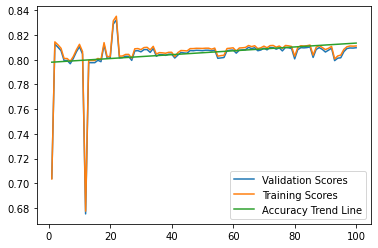

In [98]:
# plot lines
plt.plot(range(1,EPOCHS + 1), valid_scores, label = "Validation Scores")
plt.plot(range(1,EPOCHS  + 1), train_scores, label = "Training Scores")
z = np.polyfit(range(1,EPOCHS + 1), train_scores, 1)
p = np.poly1d(z)
plt.plot(range(1,EPOCHS + 1), p(range(1,EPOCHS + 1)), label = 'Accuracy Trend Line')
plt.legend()
plt.show()

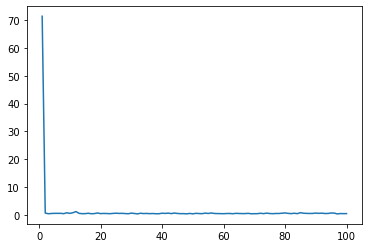

In [17]:
plt.plot(range(1,EPOCHS  + 1), losses, label = "Losses")

# comment
_Based on the output of the first plot, it looks like the training and validation accuracy increases (very slightly) as the number of epochs increases. We can see this with the trend line on the graph. With the loss plotted against the number of epochs, we see the opposite is true and that it overall decreases as the number of epochs increases. This is because the first loss is extremely high while the following losses are relatively low. Since the the first loss is computed without any training, then it is going to be high at first. Since the Validation Accuracy follows pretty close to the Training Accuracy, there seems to be no overfitting happening. For overfitting, I would expect that the training accuracy would be much higher than the validation accuracy._

### Part d 
Evaluate the model on the test dataset. Print out the accuracy. Does this accuracy agree with the training accuracy showed on the plot?

In [20]:
test_criterion = nn.CrossEntropyLoss(reduction='sum')
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += test_criterion(output, target).item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
print('Test Accuracy: {}/{} = {}'.format(correct,len(test_loader.dataset),correct/len(test_loader.dataset)))

Test Accuracy: 79949/98804 = 0.809167645034614


# comment
_Based on what the plot from part c shows, the testing accuracy matches what we'd expect after training and validating the model on seen data and exposing it to unseen data. It looks like the max accuracy of the training and validating gets to be close to 84% while the test accuracy is about an 81%._

## Problem 2

In this problem, we will investigate the effects of various common hyperparameters on the performance of a neural network. In the following cell, you can find a network class already defined for you. You can initiate network instances with different hyperparameters by changing the contructor's arguments.

You are graded based on how you implement and execute the experiments. Since there is some randomness in initiating and training a neural network, there is no guarantee that you will get an expected result for an experiment or that your results should be similar to those of your peers. The expected outcome is that you execute the experiments correctly and the conclusion you get are consistent with your results. For each experiments, try to run the code multiple times and record the average results like what we did in Homework 2 (it will take some time to run, as expected when training any neural network).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class mnist_network(torch.nn.Module):
    
    def __init__(self, num_hidden_layers=1, layer_size = 100, activation=None):
        super(mnist_network, self).__init__()
        # layers of the network
        self.num_hidden_layers = num_hidden_layers
        self.layer_size = layer_size
        self.activation = activation

        if(self.activation == 'relu'):
            self.activation = F.relu
        elif(self.activation == 'tanh'):
            self.activation = torch.tanh
        elif(self.activation == 'sigmoid'): # added this line
            self.activation = torch.nn.Sigmoid # and this one

        self.layers = nn.ModuleList([nn.Linear(784,self.layer_size)])
        for i in range(1, self.num_hidden_layers):
            self.layers.append(nn.Linear(self.layer_size,self.layer_size))
        self.layers.append(nn.Linear(self.layer_size,10))

    def forward(self, x):
        # converting each image into a vector
        batch_size = x.shape[0]
        x = x.reshape(batch_size,-1)
        # rest of the forward pass 
        for i in range(self.num_hidden_layers+1):
            x = self.layers[i](x)
            if(self.activation != None):
                x = self.activation(x)
        return x

Run the following code to load the MNIST dataset. For the sake of simplicity, we do not have a validation set in this problem.

In [2]:
import torch
from torchvision import datasets, transforms

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)

# DataLoader is a nice tool provided by PyTorch for passing training or testing examples
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

Here is an example of training and testing a model:

In [3]:
def train(model, criterion, train_loader, optimizer, epoch):
    # Turn the model to training mode (gradients will be calculated)
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We have to call zero_grad() on the optimizer to remove gradients from the previous data pass.
        # Otherwise, the gradients will be accumulated throughout many passes.
        optimizer.zero_grad()
        # Pass in the data and obtain the output.
        # When you pass the data directly by calling model(data), the model will internally pass the data through the forward() function.
        output = model(data)
        # Compare the output and the ground truth and calculate the loss.
        loss = criterion(output, target)
        # From the calculated loss, call backward() to calculate the gradients for all the paramters in the network.
        loss.backward()
        # Update the parameters according to the gradients. 
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, criterion, test_loader):
    # Turn the model to testing mode (gradients will not be calculated)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [24]:
# Number of training epochs
epochs = 5
# Learning rate
lr = 0.01

# Create the model
model = mnist_network(num_hidden_layers=1,layer_size=20,activation='relu')

# Define the training and testing loss
train_criterion = nn.CrossEntropyLoss()
test_criterion = nn.CrossEntropyLoss(reduction='sum')

# Define the optimizer
# We have to specify the learning rate and the parameters that the optimizer should update during training.
# In this case, we specify that the optimizer should update all the parameters from our model.
optimizer = optim.SGD(model.parameters(),lr=lr)

for epoch in range(1,1+epochs):
        # Training
        train(model, train_criterion, train_loader, optimizer, epoch)
        # Testing
        test(model, test_criterion, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303005
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.698578
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.094308
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.884926
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.659386
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.872297
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.788716
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.121195
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.850268
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.800012

Test set: Average loss: 0.7488, Accuracy: 8150/10000 (82%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.686632
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.896054
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.701346
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.654898
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.511969
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.770084
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.654108
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.064980
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.758033
T

## Part a

First, we will investigate the effect of varying the size of the hidden layer. Create 3 one-hidden-layer networks with the sizes of the hidden layers being 5, 20, 50, respectively. We will call these the 5-network, the 20-network, and the 50-network. All networks should use ReLU activation.

**will create the networks within their respective cells so when I rerun it wont be trained already**

Train the 5-network on the MNIST dataset for 10 epochs with learning rate 0.001. After each epoch, record the current training accuracy of the network. 

In [5]:
np.random.seed(2)
# Number of training epochs
epochs = 10
# Learning rate
lr = 0.001

# Define the training and testing loss
train_criterion = nn.CrossEntropyLoss()
test_criterion = nn.CrossEntropyLoss(reduction='sum')

# Define the optimizer
# We have to specify the learning rate and the parameters that the optimizer should update during training.
# In this case, we specify that the optimizer should update all the parameters from our model.

# define the five-network
five_model = mnist_network(num_hidden_layers=1,layer_size=5,activation='relu')

# create optimizer for the 5-network
five_optimizer = optim.SGD(five_model.parameters(),lr=lr)

# initialize an emp
five_model_accuracies = []


for epoch in range(1,epochs+1):
    # Training the five-network
    train(five_model, train_criterion, train_loader, five_optimizer, epoch)
        
    # use test function to get the performance 
    five_model.eval()
    train_loss = 0
    num_correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            output = five_model(data)
            train_loss += test_criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            num_correct += pred.eq(target.view_as(pred)).sum().item()

    five_model_accuracies.append(num_correct / len(train_loader.dataset))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.382977
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.190428
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.112933
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.048495
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.018739
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.933065
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.708500
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.998135
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.746063
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.462017
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.618658
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.477855
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.463898
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.374288
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.372230
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.418761
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.250929
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.524912
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.372139
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.075894
Train Epoch:

In [6]:
print(five_model_accuracies)

[0.5118833333333334, 0.6109166666666667, 0.6497833333333334, 0.6712, 0.6860166666666667, 0.6977166666666667, 0.7065333333333333, 0.7143333333333334, 0.7206, 0.7703833333333333]


Test the trained 5-network on the test data. Print out the accuracy.

In [7]:
np.random.seed(46)
test(five_model, test_criterion, test_loader)


Test set: Average loss: 0.8030, Accuracy: 7802/10000 (78%)



Train the 20-network on the MNIST dataset for 10 epochs with learning rate 0.001. After each epoch, record the current training accuracy of the network. 

In [8]:
np.random.seed(3)

# define the twenty-network
twenty_model = mnist_network(num_hidden_layers=1,layer_size=20,activation='relu')

# create optimizer for the twenty-network
twenty_optimizer = optim.SGD(twenty_model.parameters(),lr=lr)

# initialize an emp
twenty_model_accuracies = []


for epoch in range(1,epochs+1):
    # Training the twenty-network
    train(twenty_model, train_criterion, train_loader, twenty_optimizer, epoch)
        
    # use test function to get the performance 
    twenty_model.eval()
    train_loss = 0
    num_correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            output = twenty_model(data)
            train_loss += test_criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            num_correct += pred.eq(target.view_as(pred)).sum().item()

    twenty_model_accuracies.append(num_correct / len(train_loader.dataset))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.332318
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.165433
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.205512
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.964749
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.001285
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.864156
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.650214
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.676998
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.470283
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.306746
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.254378
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.059246
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.177335
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.937805
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.896074
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.853867
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.754357
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.939809
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.882449
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.756683
Train Epoch:

In [9]:
print(twenty_model_accuracies)

[0.7548166666666667, 0.8387, 0.8612333333333333, 0.8741, 0.8824, 0.88795, 0.8927, 0.8961166666666667, 0.8991333333333333, 0.9019166666666667]


Test the trained 20-network on the test data. Print out the accuracy.

In [10]:
np.random.seed(44)
test(twenty_model, test_criterion, test_loader)


Test set: Average loss: 0.3320, Accuracy: 9060/10000 (91%)



Train the 50-network on the MNIST dataset for 10 epochs with learning rate 0.001. After each epoch, record the current training accuracy of the network. 

In [11]:
np.random.seed(4)

# define the fifty-network
fifty_model = mnist_network(num_hidden_layers=1,layer_size=50,activation='relu')

# create optimizer for the 50-network
fifty_optimizer = optim.SGD(fifty_model.parameters(),lr=lr)

# initialize an emp
fifty_model_accuracies = []


for epoch in range(1,epochs+1):
    # Training the fifty-network
    train(fifty_model, train_criterion, train_loader, fifty_optimizer, epoch)
        
    # use test function to get the performance 
    fifty_model.eval()
    train_loss = 0
    num_correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            output = fifty_model(data)
            train_loss += test_criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            num_correct += pred.eq(target.view_as(pred)).sum().item()

    fifty_model_accuracies.append(num_correct / len(train_loader.dataset))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315129
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.249916
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.136567
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.907862
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.838665
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.745965
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.500738
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.687810
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.390489
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.229845
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.237610
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.237765
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.261933
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.905777
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.980741
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.069207
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.885865
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.265059
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.956839
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.800972
Train Epoch:

In [12]:
print(fifty_model_accuracies)

[0.7414833333333334, 0.7884833333333333, 0.8048166666666666, 0.85305, 0.8762166666666666, 0.8851833333333333, 0.8915333333333333, 0.8960333333333333, 0.8997333333333334, 0.9027833333333334]


Test the trained 50-network on the test data. Print out the accuracy.

In [13]:
np.random.seed(42)
test(fifty_model, test_criterion, test_loader)


Test set: Average loss: 0.3297, Accuracy: 9070/10000 (91%)



Plot the training accuracies over the epochs of the networks on the same figure (there should 3 line plots/scatter plots). 

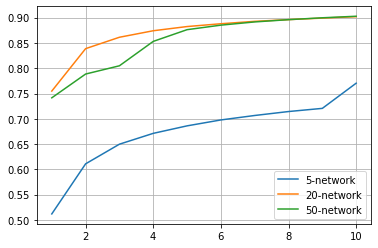

In [14]:
# plot lines
plt.plot(range(1,epochs + 1), five_model_accuracies, label = "5-network")
plt.plot(range(1,epochs + 1), twenty_model_accuracies, label = "20-network")
plt.plot(range(1,epochs + 1), fifty_model_accuracies, label = "50-network")
plt.legend()
plt.grid()
plt.show()

What is your conclustion on the effect of varying the hidden layer size on the performance of a neural network trained on the MNIST dataset?

# comment
_Looking at the plot, we can tell its obvious that as the number of epochs increases, so does the accuracy. At the beginning, when we just start to train the model (epochs 1 - 3), the accuracy is low, especially for the 5-network. The best performing network right at 1 epoch is the 20-network with about a 76% accuracy. However, once we get to the end of the training period (completed the 10 epochs), the 20 and 50-network have around the same accuracy. Technically in the end, the 50-network is the best performing, but the 20-network is not that far away. After running this exact question multiple times and seeing different results each time, I conclude that by increasing the size of the hidden layer, the performance of the neural network increases, however once you get to a certain point, the size of the hidden layer doesnt improve much. This is evident especially in this example where the 20 and 50-network converge to the same accuracy. Since there is some variability in what you get when you run these networks multiple times, I noticed that the 20-network is the one that performs the most consistent. I believe this has to do with the tradeoff of being not too complex but not too generalized, which makes sense since it is the middle value between the two hidden layer sizes we are checking._ 

## Part b

Now, we will investigate the effect of varying the number of hidden layers. Create 3 networks with 1, 2, and 3 hidden layers, respectively. The size of all hidden layers should be 20 and the activation function is ReLU. We will call these the 1-network, the 2-network, and the 3-network.

Train the 1-network on the MNIST dataset for 10 epochs with learning rate 0.001. After each epoch, record the current training accuracy of the network. 

In [15]:
np.random.seed(4)
# Number of training epochs
epochs = 10
# Learning rate
lr = 0.001

# define the one-network
one_model = mnist_network(num_hidden_layers=1,layer_size=20,activation='relu')

# create optimizer for the 1-network
one_optimizer = optim.SGD(one_model.parameters(),lr=lr)

# initialize an emp
one_model_accuracies = []


for epoch in range(1,epochs+1):
    # Training the one-network
    train(one_model, train_criterion, train_loader, one_optimizer, epoch)
        
    # use test function to get the performance 
    one_model.eval()
    train_loss = 0
    num_correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            output = one_model(data)
            train_loss += test_criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            num_correct += pred.eq(target.view_as(pred)).sum().item()

    one_model_accuracies.append(num_correct / len(train_loader.dataset))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300323
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.270432
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.201476
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.996546
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.075665
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.050701
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.841506
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.834021
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.638700
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.602660
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.639453
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.583329
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.502825
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.218866
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.526678
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.405886
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.152557
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.225761
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.125175
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.066173
Train Epoch:

In [16]:
print(one_model_accuracies)

[0.5272166666666667, 0.7649666666666667, 0.7908166666666666, 0.8010333333333334, 0.8064666666666667, 0.8109166666666666, 0.81405, 0.8173333333333334, 0.8200166666666666, 0.82225]


Test the trained 1-network on the test data. Print out the accuracy.

In [17]:
np.random.seed(68)
test(one_model, test_criterion, test_loader)


Test set: Average loss: 0.5642, Accuracy: 8233/10000 (82%)



Train the 2-network on the MNIST dataset for 10 epochs with learning rate 0.001. After each epoch, record the current training accuracy of the network. 

In [18]:
np.random.seed(5)
# Number of training epochs
epochs = 10
# Learning rate
lr = 0.001

# define the two-network
two_model = mnist_network(num_hidden_layers=2,layer_size=20,activation='relu')

# create optimizer for the 2-network
two_optimizer = optim.SGD(two_model.parameters(),lr=lr)

# initialize an emp
two_model_accuracies = []


for epoch in range(1,epochs+1):
    # Training the two-network
    train(two_model, test_criterion, train_loader, two_optimizer, epoch)
        
    # use test function to get the performance 
    two_model.eval()
    train_loss = 0
    num_correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            output = two_model(data)
            train_loss += test_criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            num_correct += pred.eq(target.view_as(pred)).sum().item()

    two_model_accuracies.append(num_correct / len(train_loader.dataset))

Train Epoch: 1 [0/60000 (0%)]	Loss: 147.813065
Train Epoch: 1 [6400/60000 (11%)]	Loss: 107.258286
Train Epoch: 1 [12800/60000 (21%)]	Loss: 56.535053
Train Epoch: 1 [19200/60000 (32%)]	Loss: 35.952488
Train Epoch: 1 [25600/60000 (43%)]	Loss: 36.090221
Train Epoch: 1 [32000/60000 (53%)]	Loss: 43.245090
Train Epoch: 1 [38400/60000 (64%)]	Loss: 34.771687
Train Epoch: 1 [44800/60000 (75%)]	Loss: 36.024658
Train Epoch: 1 [51200/60000 (85%)]	Loss: 38.258026
Train Epoch: 1 [57600/60000 (96%)]	Loss: 21.605701
Train Epoch: 2 [0/60000 (0%)]	Loss: 24.543703
Train Epoch: 2 [6400/60000 (11%)]	Loss: 21.082384
Train Epoch: 2 [12800/60000 (21%)]	Loss: 24.859507
Train Epoch: 2 [19200/60000 (32%)]	Loss: 26.597393
Train Epoch: 2 [25600/60000 (43%)]	Loss: 24.304577
Train Epoch: 2 [32000/60000 (53%)]	Loss: 38.142662
Train Epoch: 2 [38400/60000 (64%)]	Loss: 29.489254
Train Epoch: 2 [44800/60000 (75%)]	Loss: 30.918945
Train Epoch: 2 [51200/60000 (85%)]	Loss: 26.868320
Train Epoch: 2 [57600/60000 (96%)]	Loss: 

In [19]:
print(two_model_accuracies)

[0.82575, 0.8458666666666667, 0.8558333333333333, 0.8611833333333333, 0.8644, 0.8665833333333334, 0.8674333333333333, 0.8688833333333333, 0.8698833333333333, 0.86875]


Test the trained 2-network on the test data. Print out the accuracy.

In [20]:
np.random.seed(70)
test(two_model, test_criterion, test_loader)


Test set: Average loss: 0.3641, Accuracy: 8629/10000 (86%)



Train the 3-network on the MNIST dataset for 10 epochs with learning rate 0.001. After each epoch, record the current training accuracy of the network. 

In [21]:
np.random.seed(6)
# Number of training epochs
epochs = 10
# Learning rate
lr = 0.001

# define the three-network
three_model = mnist_network(num_hidden_layers=3,layer_size=20,activation='relu')

# create optimizer for the 3-network
three_optimizer = optim.SGD(three_model.parameters(),lr=lr)

# initialize an emp
three_model_accuracies = []


for epoch in range(1,epochs+1):
    # Training the three-network
    train(three_model, train_criterion, train_loader, three_optimizer, epoch)
        
    # use test function to get the performance 
    three_model.eval()
    train_loss = 0
    num_correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            output = three_model(data)
            train_loss += test_criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            num_correct += pred.eq(target.view_as(pred)).sum().item()

    three_model_accuracies.append(num_correct / len(train_loader.dataset))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301425
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.304820
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.310930
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.316746
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.309440
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.295924
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.273448
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.298952
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.298415
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.292529
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.276950
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.284822
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.293906
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.299333
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.285742
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.272441
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.244082
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.275678
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.276724
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.266499
Train Epoch:

In [22]:
print(three_model_accuracies)

[0.10518333333333334, 0.26005, 0.31805, 0.35785, 0.3944666666666667, 0.4849833333333333, 0.6042, 0.6636666666666666, 0.7024166666666667, 0.7319]


Test the trained 3-network on the test data. Print out the accuracy.

In [23]:
np.random.seed(72)
test(three_model, test_criterion, test_loader)


Test set: Average loss: 0.9307, Accuracy: 7328/10000 (73%)



Plot the training accuracies over the epochs of the networks on the same figure (there should 3 line plots/scatter plots). 

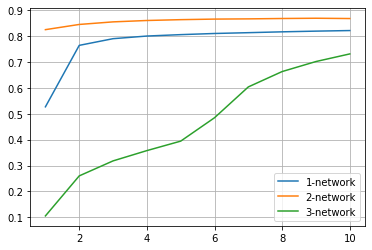

In [24]:
# plot lines
plt.plot(range(1,epochs + 1), one_model_accuracies, label = "1-network")
plt.plot(range(1,epochs + 1), two_model_accuracies, label = "2-network")
plt.plot(range(1,epochs + 1), three_model_accuracies, label = "3-network")
plt.legend()
plt.grid()
plt.show()

What is your conclustion on the effect of varying the number of hidden layers on the performance of a neural network trained on the MNIST dataset?

# comment
_Based on the plot above, the 2-network seems to perform  the best overall with an average accuracy of about 85%. Similar to the situation in part a, the accuracy still increases, but at a slower rate than before. The next highest performing network is the 1-network with an average accuracy of about 75% followed by the 3-network with an average accuracy of about 40%. Just like what I mentioned in the previous part, I believe that increasing the number of hidden layers might also increase complexity which in turn increases the variance. Conversely, decreasing the number of hidden layers might lead to a higher bias, via the bias variance trade off. This could be the reason why the 2-network, the middle/tradeoff level performs the best._

## Part c

Next, we will investigate the effects of varying the activation functions on a neural network. Create 3 networks. The first network has Sigmoid activation (Sigmoid-network). The second network has ReLU activation (ReLU-network). The third network has Tanh activation (Tanh-network). All networks have one hidden layer with size 20.

Train the Sigmoid-network on the MNIST dataset for 10 epochs with learning rate 0.001. After each epoch, record the current training accuracy of the network. 

In [32]:
np.random.seed(4)
# Number of training epochs
epochs = 10
# Learning rate
lr = 0.001

# define the sigmoid-network
sigmoid_model = mnist_network(num_hidden_layers=1,layer_size=20)
sigmoid_model.activation = torch.nn.Sigmoid()

# create optimizer for the sigmoid-network
sigmoid_optimizer = optim.SGD(sigmoid_model.parameters(),lr=lr)

# initialize an emp
sigmoid_model_accuracies = []


for epoch in range(1,epochs+1):
    # Training the sigmoid-network
    train(sigmoid_model, train_criterion, train_loader, sigmoid_optimizer, epoch)
        
    # use test function to get the performance 
    sigmoid_model.eval()
    train_loss = 0
    num_correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            output = sigmoid_model(data)
            train_loss += test_criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            num_correct += pred.eq(target.view_as(pred)).sum().item()

    sigmoid_model_accuracies.append(num_correct / len(train_loader.dataset))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309737
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.314262
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.286859
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.310013
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.292585
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.295747
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.297938
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.298479
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.300939
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.285291
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.293699
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.298695
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.277181
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.291199
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.279037
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.281797
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.280839
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.287729
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.285729
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.270517
Train Epoch:

Test the trained Sigmoid-network on the test data. Print out the accuracy.

In [33]:
np.random.seed(72)
test(sigmoid_model, test_criterion, test_loader)


Test set: Average loss: 2.1926, Accuracy: 6371/10000 (64%)



Train the ReLU-network on the MNIST dataset for 10 epochs with learning rate 0.001. After each epoch, record the current training accuracy of the network. 

In [34]:
np.random.seed(5)
# Number of training epochs
epochs = 10
# Learning rate
lr = 0.001

# define the relu-network
relu_model = mnist_network(num_hidden_layers=1,layer_size=20,activation='relu')

# create optimizer for the relu-network
relu_optimizer = optim.SGD(relu_model.parameters(),lr=lr)

# initialize an emp
relu_model_accuracies = []


for epoch in range(1,epochs+1):
    # Training the relu-network
    train(relu_model, test_criterion, train_loader, relu_optimizer, epoch)
        
    # use test function to get the performance 
    relu_model.eval()
    train_loss = 0
    num_correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            output = relu_model(data)
            train_loss += test_criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            num_correct += pred.eq(target.view_as(pred)).sum().item()

    relu_model_accuracies.append(num_correct / len(train_loader.dataset))

Train Epoch: 1 [0/60000 (0%)]	Loss: 147.866287
Train Epoch: 1 [6400/60000 (11%)]	Loss: 51.347614
Train Epoch: 1 [12800/60000 (21%)]	Loss: 41.548210
Train Epoch: 1 [19200/60000 (32%)]	Loss: 27.462687
Train Epoch: 1 [25600/60000 (43%)]	Loss: 15.960865
Train Epoch: 1 [32000/60000 (53%)]	Loss: 20.419659
Train Epoch: 1 [38400/60000 (64%)]	Loss: 14.096617
Train Epoch: 1 [44800/60000 (75%)]	Loss: 23.897438
Train Epoch: 1 [51200/60000 (85%)]	Loss: 18.115345
Train Epoch: 1 [57600/60000 (96%)]	Loss: 20.187700
Train Epoch: 2 [0/60000 (0%)]	Loss: 9.133462
Train Epoch: 2 [6400/60000 (11%)]	Loss: 9.445862
Train Epoch: 2 [12800/60000 (21%)]	Loss: 12.739426
Train Epoch: 2 [19200/60000 (32%)]	Loss: 15.625753
Train Epoch: 2 [25600/60000 (43%)]	Loss: 9.118756
Train Epoch: 2 [32000/60000 (53%)]	Loss: 13.663810
Train Epoch: 2 [38400/60000 (64%)]	Loss: 9.131331
Train Epoch: 2 [44800/60000 (75%)]	Loss: 18.964642
Train Epoch: 2 [51200/60000 (85%)]	Loss: 9.663550
Train Epoch: 2 [57600/60000 (96%)]	Loss: 15.764

Test the trained ReLU-network on the test data. Print out the accuracy.

In [35]:
np.random.seed(72)
test(relu_model, test_criterion, test_loader)


Test set: Average loss: 0.1418, Accuracy: 9590/10000 (96%)



Train the Tanh-network on the MNIST dataset for 10 epochs with learning rate 0.001. After each epoch, record the current training accuracy of the network. 

In [36]:
np.random.seed(6)
# Number of training epochs
epochs = 10
# Learning rate
lr = 0.001

# define the tanh-network
tanh_model = mnist_network(num_hidden_layers=1,layer_size=20,activation='tanh')

# create optimizer for the tanh-network
tanh_optimizer = optim.SGD(tanh_model.parameters(),lr=lr)

# initialize an emp
tanh_model_accuracies = []


for epoch in range(1,epochs+1):
    # Training the tanh-network
    train(tanh_model, test_criterion, train_loader, tanh_optimizer, epoch)
        
    # use test function to get the performance 
    tanh_model.eval()
    train_loss = 0
    num_correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            output = tanh_model(data)
            train_loss += test_criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            num_correct += pred.eq(target.view_as(pred)).sum().item()

    tanh_model_accuracies.append(num_correct / len(train_loader.dataset))

Train Epoch: 1 [0/60000 (0%)]	Loss: 150.853760
Train Epoch: 1 [6400/60000 (11%)]	Loss: 81.846916
Train Epoch: 1 [12800/60000 (21%)]	Loss: 76.146347
Train Epoch: 1 [19200/60000 (32%)]	Loss: 72.989250
Train Epoch: 1 [25600/60000 (43%)]	Loss: 67.271271
Train Epoch: 1 [32000/60000 (53%)]	Loss: 69.263687
Train Epoch: 1 [38400/60000 (64%)]	Loss: 67.035652
Train Epoch: 1 [44800/60000 (75%)]	Loss: 68.369438
Train Epoch: 1 [51200/60000 (85%)]	Loss: 68.933815
Train Epoch: 1 [57600/60000 (96%)]	Loss: 64.686821
Train Epoch: 2 [0/60000 (0%)]	Loss: 61.676388
Train Epoch: 2 [6400/60000 (11%)]	Loss: 62.779221
Train Epoch: 2 [12800/60000 (21%)]	Loss: 62.749035
Train Epoch: 2 [19200/60000 (32%)]	Loss: 63.402489
Train Epoch: 2 [25600/60000 (43%)]	Loss: 61.274143
Train Epoch: 2 [32000/60000 (53%)]	Loss: 64.712128
Train Epoch: 2 [38400/60000 (64%)]	Loss: 62.924973
Train Epoch: 2 [44800/60000 (75%)]	Loss: 64.448326
Train Epoch: 2 [51200/60000 (85%)]	Loss: 65.019363
Train Epoch: 2 [57600/60000 (96%)]	Loss: 6

Test the trained Tanh-network on the test data. Print out the accuracy.

In [37]:
np.random.seed(72)
test(tanh_model, test_criterion, test_loader)


Test set: Average loss: 0.9202, Accuracy: 9391/10000 (94%)



Plot the training accuracies over the epochs of the networks on the same figure (there should 3 line plots/scatter plots). 

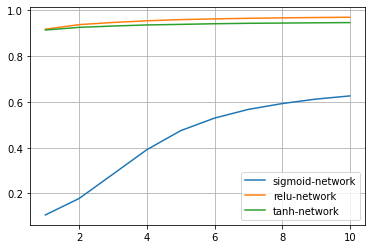

In [38]:
# plot lines
plt.plot(range(1,epochs + 1), sigmoid_model_accuracies, label = "sigmoid-network")
plt.plot(range(1,epochs + 1), relu_model_accuracies, label = "relu-network")
plt.plot(range(1,epochs + 1), tanh_model_accuracies, label = "tanh-network")
plt.legend()
plt.grid()
plt.show()

What is your conclusion on the effect of varying the activation functions on the performance of a neural network trained on MNIST dataset?

# comment
_By varying the activation functions, we see that the best performing activation function is relu. Closely following relu is tanh and the worst performing activation function is sigmoid. Although there isn't much of a difference if we change the activation function from relu to tanh and vice versa (since they both end at a value of about 96% /97%), we see that the sigmoid, as expected, follows a logistic curve and only converges to 63% at the end of the 10th epoch. So using tanh or relu would be the best suggestion compared to sigmoid for the activation function._

## Part d

Finally, we will look into the effect of varying the value of the learning rate on the performance of a neural network. Create a network with one hidden layer of size 20 and ReLU activation.

Train the network on the MNIST dataset for 10 epochs. Set the learning rate to be 0.1. After each epoch, record the current training accuracy of the network. 

In [39]:
np.random.seed(4)
# Number of training epochs
epochs = 10
# Learning rate
lr = 0.1

# define the tenth-network
tenth_model = mnist_network(num_hidden_layers=1,layer_size=20,activation='relu')

# create optimizer for the tenth-network
tenth_optimizer = optim.SGD(tenth_model.parameters(),lr=lr)

# initialize an emp
tenth_model_accuracies = []


for epoch in range(1,epochs+1):
    # Training the tenth-network
    train(tenth_model, train_criterion, train_loader, tenth_optimizer, epoch)
        
    # use test function to get the performance 
    tenth_model.eval()
    train_loss = 0
    num_correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            output = tenth_model(data)
            train_loss += test_criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            num_correct += pred.eq(target.view_as(pred)).sum().item()

    tenth_model_accuracies.append(num_correct / len(train_loader.dataset))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298168
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.539162
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.419262
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.528268
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.363742
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.648163
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.468586
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.537555
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.457820
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.569704
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.273476
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.392620
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.251340
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.457069
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.298622
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.588504
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.391574
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.479404
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.463274
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.495992
Train Epoch:

Test the trained network on the test data. Print out the accuracy.

In [40]:
np.random.seed(72)
test(tenth_model, test_criterion, test_loader)


Test set: Average loss: 0.3657, Accuracy: 8667/10000 (87%)



Train the network on the MNIST dataset for 10 epochs. Set the learning rate to be 0.01. After each epoch, record the current training accuracy of the network. 

In [41]:
np.random.seed(5)
# Number of training epochs
epochs = 10
# Learning rate
lr = 0.01

# define the hund-network
hund_model = mnist_network(num_hidden_layers=1,layer_size=20,activation='relu')

# create optimizer for the hund-network
hund_optimizer = optim.SGD(hund_model.parameters(),lr=lr)

# initialize an emp
hund_model_accuracies = []


for epoch in range(1,epochs+1):
    # Training the hund-network
    train(hund_model, train_criterion, train_loader, hund_optimizer, epoch)
        
    # use test function to get the performance 
    hund_model.eval()
    train_loss = 0
    num_correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            output = hund_model(data)
            train_loss += test_criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            num_correct += pred.eq(target.view_as(pred)).sum().item()

    hund_model_accuracies.append(num_correct / len(train_loader.dataset))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327361
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.246654
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.070409
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.580138
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.373426
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.437107
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.331501
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.472921
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.431582
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.414553
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.298457
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.314229
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.238759
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.372703
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.231804
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.345702
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.225372
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.388469
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.347101
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.400886
Train Epoch:

Test the trained network on the test data. Print out the accuracy.

In [42]:
np.random.seed(72)
test(hund_model, test_criterion, test_loader)


Test set: Average loss: 0.1871, Accuracy: 9419/10000 (94%)



Train the network on the MNIST dataset for 10 epochs. Set the learning rate to 0.001. After each epoch, record the current training accuracy of the network. 

In [43]:
np.random.seed(6)
# Number of training epochs
epochs = 10
# Learning rate
lr = 0.001

# define the thou-network
thou_model = mnist_network(num_hidden_layers=1,layer_size=20,activation='relu')

# create optimizer for the thou-network
thou_optimizer = optim.SGD(thou_model.parameters(),lr=lr)

# initialize an emp
thou_model_accuracies = []


for epoch in range(1,epochs+1):
    # Training the thou-network
    train(thou_model, train_criterion, train_loader, thou_optimizer, epoch)
        
    # use test function to get the performance 
    thou_model.eval()
    train_loss = 0
    num_correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            output = thou_model(data)
            train_loss += test_criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            num_correct += pred.eq(target.view_as(pred)).sum().item()

    thou_model_accuracies.append(num_correct / len(train_loader.dataset))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333499
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.258330
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.213496
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.137605
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.142013
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.114271
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.062809
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.001007
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.875035
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.715694
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.908723
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.660475
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.599771
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.559290
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.573894
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.516460
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.574278
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.622074
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.515048
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.319931
Train Epoch:

Test the trained network on the test data. Print out the accuracy.

In [44]:
np.random.seed(72)
test(thou_model, test_criterion, test_loader)


Test set: Average loss: 0.5856, Accuracy: 8210/10000 (82%)



Plot the training accuracies over the epochs of the scenarios on the same figure (there should 3 line plots/scatter plots). 

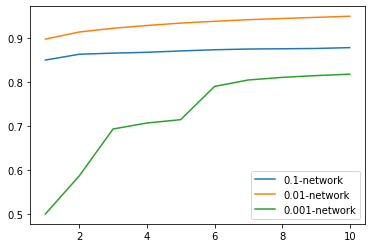

In [45]:
# plot lines
plt.plot(range(1,epochs + 1), tenth_model_accuracies, label = "0.1-network")
plt.plot(range(1,epochs + 1), hund_model_accuracies, label = "0.01-network")
plt.plot(range(1,epochs + 1), thou_model_accuracies, label = "0.001-network")
plt.legend()
plt.show()

What is your conclustion on the effect of varying the learning rate on the performance of a neural network?

# comment
_Based on the plot above, the middle higher learning rate produces higher/better performing models. The best, 0.01-network, ends with an accuracy score of about 97%. Following that is the 0.1-network with about a 88% and finally the 0.001-network with about an 82%. This also follows my theory on the bias variance tradeoff since the best performing network (0.01) is the middle / tradeoff between the two. I find it interesting that although the higher learning rates have overall higher performance values, the 0.001-network increases the fastest over all the epochs._

## REMARK for Problem 2

You have observed the effects of varying different hyperparameters on the performance of a neural network **on the MNIST dataset**. However, keep in mind that these trends only apply for **the MNIST dataset** and should not be carried to another problem. There is no single hyperparameter settings that works for all problems. As you do more problems, you will build up your intuitions about the hyperparameters so that you can quickly deploy a good model. For example, people observed that setting the learning rate = 0.001 often works the best, though it is not always the case.

## Problem 3

Experimenting with **k-anomity, i-diversity, and t-closeness**. 

Consider a dataset, for example, with 3 ordinary attributes and 1 sensitive attribute. Let the 3 ordinary attributes be Age, Sex, and Education and the sensitive attribute be Income, each row in this dataset is of the form:

$$
    [Age, Sex, Education, Income]
$$

A hacker is interested in knowing the sensitive attribute Income. When the dataset is designed so that if complies with either **k-anomity**, **i-diversity**, and/or **t-closeness**, even if he or she somehow figures out the values of the three, the hacker may not retrive the sensitive information accurately. In general, **k-anomity** is weaker than **i-diversity**, which, in turn, is weaker than **t-closeness**.

By definition, **k-anomity** means that there is at least **k** different rows in the table of which ordinary values are a particular combination of Age, Sex, and Education. For example, the hacker knows the information of the person of interest is Age = 31, Sex = Female, and Education = BS. He or she looks into the data table and found that there are 3 rows with that combination:

$$
    [Age=31, Sex=Female, Education=BS, Income=300k]
$$
$$
    [Age=31, Sex=Female, Education=BS, Income=70k]
$$
$$
    [Age=31, Sex=Female, Education=BS, Income=20k]
$$

The hacker cannot tell accurately what the income of the person is because it can be one of the 3 values shown. This particular combination of information has 3-anomity. If every combination corresponds to at least 3 rows, then the dataset has 3-anomity.

a) Let's look at the dataset **"table.csv"**. Let the sensitive attribute be **education** and others be ordinary attributes. Calculate the anomity of the dataset (the value **k**). First, find all the posible combinations of the ordinary attributes that exists in the dataset. After that, determine the anomity for each combination. The anomity of the dataset is the smallest anomity among the combinations.

In [46]:
table = pd.read_csv('table.csv')
table

,Unnamed: 0,age,education,race,sex
0,0,39,Bachelors,White,Male
1,1,50,Bachelors,White,Male
2,2,38,HS-grad,White,Male
3,3,53,11th,Black,Male
4,4,28,Bachelors,Black,Female
...,...,...,...,...,...
32556,32556,27,Assoc-acdm,White,Female
32557,32557,40,HS-grad,White,Male
32558,32558,58,HS-grad,White,Female
32559,32559,22,HS-grad,White,Male


In [47]:
table.groupby(['age','race','sex']).count().sort_values('Unnamed: 0').head(5)

,,,Unnamed: 0,education
age,race,sex,,
49,Amer-Indian-Eskimo,Female,1,1
48,Amer-Indian-Eskimo,Female,1,1
74,Amer-Indian-Eskimo,Male,1,1
48,Amer-Indian-Eskimo,Male,1,1
74,Other,Female,1,1


# COMMENT
_To calculate the k-anonymity, I took the dataset, grouped together the ordinary attributes and counted all the unique combinations of those unique combinations. Based on the code above where I find the counts of each unique combination, the lowest number of observations with a specific combination is 1. Thus since we can easily figure out the identity of those individuals with a combination that only refers to them within this dataset, our k-anonymity is 1._

We can improve the **k-anomity** of the dataset by "suppressing" the ordinary attributes. Suppressing means reducing the resolution of the attribute's value. For this problem, let's suppress Age by replacing the exact age with an age range. For example, instead of leaving age = 32, replace it with age = 30-40. Apply this to **"table.csv"** with the ranges {<20, 20-30, 30-50, >50}. Check if the anomity improves. 

In [48]:
# define a simple function that can be applied to the table
def age_range(age):
    if age < 20:
        return '<20'
    elif age <= 30:
        return '20-30'
    elif age <= 50:
        return '30-50'
    else:
        return '>50'

table['age'] = table['age'].apply(age_range)  
table.head(10)

,Unnamed: 0,age,education,race,sex
0,0,30-50,Bachelors,White,Male
1,1,30-50,Bachelors,White,Male
2,2,30-50,HS-grad,White,Male
3,3,>50,11th,Black,Male
4,4,20-30,Bachelors,Black,Female
5,5,30-50,Masters,White,Female
6,6,30-50,9th,Black,Female
7,7,>50,HS-grad,White,Male
8,8,30-50,Masters,White,Female
9,9,30-50,Bachelors,White,Male


In [49]:
# running the same code from earlier to check value counts
table.groupby(['age','race','sex']).count().sort_values('Unnamed: 0').head(5)

Unnamed: 0  education
age race               sex                          
<20 Amer-Indian-Eskimo Male             4          4
    Other              Male             5          5
>50 Other              Female           7          7
<20 Asian-Pac-Islander Male             8          8
    Amer-Indian-Eskimo Female           9          9

# comment
_After supressing the ordinary attributes, we were able to find that at least 4 indivduals make up every single unique combination of ordianry attributes in this dataset. Hence the k-anonymity is 4._

**K-anomity** is nice, however, it fails in many cases. If the rows which share a combination of ordinary attributes have only a few values for the sensitive attribute, then it is not much better than having no anomity at all. For example, consider:

$$
    [Age=31, Sex=Female, Education=BS, Income=300k]
$$
$$
    [Age=31, Sex=Female, Education=BS, Income=20k]
$$
$$
    [Age=31, Sex=Female, Education=BS, Income=20k]
$$
$$
    [Age=31, Sex=Female, Education=BS, Income=20k]
$$

When **k-anomity** fails in the second case, **i-diversity** comes to the rescue. **I-diversity** states that the rows of a particular combination of information must have at least i different values for the sensitive attribute. The above example has 2-diversity, which is not good. 

b) Calculate the **i-diversity** of the dataset **"table.csv"**. Follow similar steps as in part a. 

In [50]:
# reload the dataset
table = pd.read_csv('table.csv')

# the following code shows the number of unique values for education for every combination
table.groupby(['age','race','sex'])['education'].nunique().sort_values()

age  race                sex   
41   Amer-Indian-Eskimo  Female     1
67   Asian-Pac-Islander  Male       1
     Amer-Indian-Eskimo  Male       1
39   Amer-Indian-Eskimo  Male       1
66   Other               Female     1
                                   ..
40   White               Male      16
64   White               Male      16
27   White               Male      16
52   White               Male      16
32   White               Male      16
Name: education, Length: 546, dtype: int64

# comment
_To calculate the i-diversity, I grouped together the ordinary attributes, but instead of just counting the number of observations for each combination, I counted the number of each unique Education response for each combination. Based on the output above, the lowest number of unique values for education for each posssible combination is 1 when there is no generalization. Therefore the i-diversity is 1._

Suppressing an attribute can also improve the **i-diversity** of the dataset. Repeat the suppression as in **part a** and check if the diversity improves. If it does not, consider further suppress age by using the range {<20, 20-50, >50}.

In [51]:
table['age'] = table['age'].apply(age_range)  
table.groupby(['age','race','sex'])['education'].nunique().sort_values()

age    race                sex   
<20    Amer-Indian-Eskimo  Male       3
                           Female     4
>50    Other               Female     4
<20    Asian-Pac-Islander  Male       4
                           Female     5
       Other               Male       5
                           Female     5
>50    Amer-Indian-Eskimo  Female     6
<20    Black               Male       6
20-30  Amer-Indian-Eskimo  Female     7
<20    Black               Female     8
20-30  Amer-Indian-Eskimo  Male       9
>50    Other               Male      10
<20    White               Male      10
>50    Amer-Indian-Eskimo  Male      10
<20    White               Female    11
30-50  Amer-Indian-Eskimo  Female    11
       Other               Female    12
20-30  Other               Female    12
       Black               Female    12
       Asian-Pac-Islander  Male      12
>50    Asian-Pac-Islander  Female    12
30-50  Amer-Indian-Eskimo  Male      13
20-30  Other               Male      13
      

# comment
_After suppressing the dataset, so the age is a range, we see that there are at least 3 different education responses for every unique combination of ordinary attributes. Thus the updated i-diversity is 3._

**Gonna try now by fixing the bounds a little more**

In [52]:
# reload the dataset
table = pd.read_csv('table.csv')

# define a simple function that can be applied to the table
def new_age_range(age):
    if age < 20:
        return '<20'
    elif age <= 50:
        return '20-50'
    else:
        return '>50'
    
# apply the new function to the table again and figure out i-diversity
table['age'] = table['age'].apply(new_age_range)  
table.groupby(['age','race','sex'])['education'].nunique().sort_values()

age    race                sex   
<20    Amer-Indian-Eskimo  Male       3
>50    Other               Female     4
<20    Amer-Indian-Eskimo  Female     4
       Asian-Pac-Islander  Male       4
       Other               Male       5
                           Female     5
       Asian-Pac-Islander  Female     5
>50    Amer-Indian-Eskimo  Female     6
<20    Black               Male       6
                           Female     8
>50    Other               Male      10
       Amer-Indian-Eskimo  Male      10
<20    White               Male      10
                           Female    11
20-50  Amer-Indian-Eskimo  Female    11
>50    Asian-Pac-Islander  Female    12
20-50  Other               Female    13
       Amer-Indian-Eskimo  Male      13
       Black               Male      15
       Asian-Pac-Islander  Male      15
>50    Asian-Pac-Islander  Male      15
       Black               Female    15
20-50  Asian-Pac-Islander  Female    15
       White               Male      16
      

# comment
_Even after suppressing the age column more, we still have at least 3 unique education responses per each unique combination so the i-diversity is still 3._

**T-closeness** is even better than **i-diversity**. **T-closeness** requires that for every combination of information, the distribution of the sensitive attribute's value among the corresponding rows must be close to the overall distribution of the sensitive attribute's value for the whole dataset. Distance between distribution is calculated using the Earth Mover Distance (EMD). The dataset has **t-closeness** if no distance exceeds **t**. 

c) Calculate the overall distribution of **education**. Find the **t-closeness** of the dataset (largest distance between any combination's distribution of marital-status and the overall distribution).

You can use **scipy.stats.wasserstein_distance** to calculate the EMD.

In [53]:
from scipy.stats import wasserstein_distance
wasserstein_distance([0, 1, 3], [5, 6, 8])

5.0

**Steps**
- length of the two lists doesnt need to be equal
- loop through all the different categories and get the values
- use that in the wasserstein distance

In [54]:
# reload the dataset
table = pd.read_csv('table.csv')

# facotrize such that
#table.iloc[:,1] = pd.factorize(table.iloc[:,1])[0]
#table.iloc[:,3] = pd.factorize(table.iloc[:,3])[0]
table.iloc[:,2] = pd.factorize(table.iloc[:,2])[0]
#table.iloc[:,4] = pd.factorize(table.iloc[:,4])[0]
table

,Unnamed: 0,age,education,race,sex
0,0,39,0,White,Male
1,1,50,0,White,Male
2,2,38,1,White,Male
3,3,53,2,Black,Male
4,4,28,0,Black,Female
...,...,...,...,...,...
32556,32556,27,6,White,Female
32557,32557,40,1,White,Male
32558,32558,58,1,White,Female
32559,32559,22,1,White,Male


In [55]:
unique_ages = np.sort(table.iloc[:,1].unique())
unique_races = np.sort(table.iloc[:,3].unique())
unique_sex = np.sort(table.iloc[:,4].unique())

In [56]:
# create a new variable to hold the actual distribution of education_values
edu_vals = table.iloc[:,2]

# store the wass_distances in a list
wass_dists = []

# iterate through every possible combination to find the education values
for age in unique_ages:
    for race in unique_races:
        for sex in unique_sex:
            
            # store new table in its own variable to get the education values
            use_df = table[(table['age'] == age) & (table['race'] == race) & (table['sex'] == sex)]
            
            # in the case where the combination does exist, input the subset of edu values
            if len(use_df) != 0:
                wass_dists.append(wasserstein_distance(use_df.iloc[:,2], edu_vals))

In [57]:
# print out the largest distance which is the t in t-closeness
max(wass_dists)

11.575535149411873

# comment
_To find the t-closeness, we have to compare the distribution of education values for each unique combination of ordinary attributes with the distribution of educations values for the whole dataset. The t in t- closeness represent the maximum distance in the whole dataset. Using wasserstein_distance, we can quantify that distance. After iterating through every unique combination, I get a max distance, or t of about 11.57 / 12._